Epoch [1/100], Loss: 0.5787
Epoch [1/100], Train Loss: 0.6792, Val Loss: 0.4873
Epoch [2/100], Loss: 0.1674
Epoch [2/100], Train Loss: 0.5335, Val Loss: 0.4045
Epoch [3/100], Loss: 0.0850
Epoch [3/100], Train Loss: 0.4929, Val Loss: 0.3225
Epoch [4/100], Loss: 0.3324
Epoch [4/100], Train Loss: 0.4420, Val Loss: 0.3205
Epoch [5/100], Loss: 0.1657
Epoch [5/100], Train Loss: 0.4142, Val Loss: 0.2894
Epoch [6/100], Loss: 0.1258
Epoch [6/100], Train Loss: 0.3771, Val Loss: 0.2657
Epoch [7/100], Loss: 0.2056
Epoch [7/100], Train Loss: 0.3437, Val Loss: 0.2602
Epoch [8/100], Loss: 0.3042
Epoch [8/100], Train Loss: 0.3355, Val Loss: 0.2178
Epoch [9/100], Loss: 0.0687
Epoch [9/100], Train Loss: 0.3383, Val Loss: 0.2038
Epoch [10/100], Loss: 0.2228
Epoch [10/100], Train Loss: 0.2907, Val Loss: 0.2185
Epoch [11/100], Loss: 0.6758
Epoch [11/100], Train Loss: 0.2976, Val Loss: 0.2434
Epoch [12/100], Loss: 0.2295
Epoch [12/100], Train Loss: 0.2798, Val Loss: 0.2287
Epoch [13/100], Loss: 0.1930
Epoch

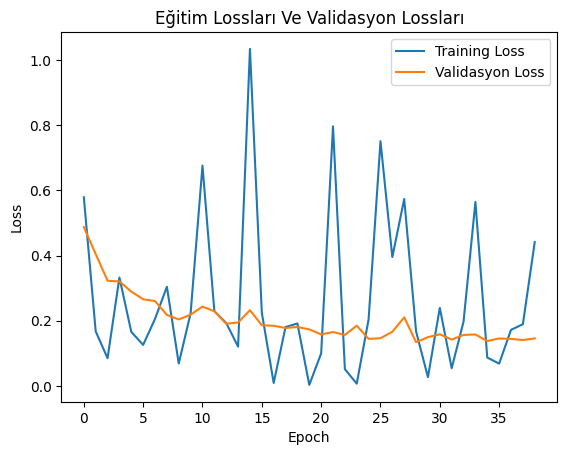

In [2]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score

torch.manual_seed(1)

# Başlangıç zamanını kaydet
start_time = time.time()

# Veri setini oku
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

# Veriyi PyTorch Tensor'larına dönüştür
X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32)
y_train = torch.tensor(train_df.iloc[:, -1].values, dtype=torch.float32)
X_val = torch.tensor(val_df.iloc[:, :-1].values, dtype=torch.float32)
y_val = torch.tensor(val_df.iloc[:, -1].values, dtype=torch.float32)
X_test = torch.tensor(test_df.iloc[:, :-1].values, dtype=torch.float32)
y_test = torch.tensor(test_df.iloc[:, -1].values, dtype=torch.float32)

# MLP modelini tanımla
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        # self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Modeli oluştur
model = MLP()

# Loss fonksiyonunu tanımla
criterion = nn.BCELoss()

# Optimizasyon yöntemini tanımla
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Early stopping için değişkenleri tanımla
best_val_loss = float('inf')
best_epoch = 0
patience = 10
current_patience = 0

# Eğitim döngüsü
epochs = 100
batch_size = 16
train_losses = [] # Eğitim losslarını saklamak için bir liste
val_losses = [] # Validasyon losslarını saklamak için bir liste

for epoch in range(epochs):
    # Batch'lerle veriyi yükle
    model.train() # Modeli eğitim modunda kullan
    train_loss = 0.0
    indices = torch.randperm(X_train.shape[0])
    for i in range(0, X_train.shape[0], batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_X = X_train[batch_indices]
        batch_y = y_train[batch_indices]
        
        # Gradientleri sıfırla
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(batch_X)
        
        # Loss hesapla
        loss = criterion(y_pred.squeeze(), batch_y)
        
        # Backward pass
        loss.backward()
        
        # Parametreleri güncelle
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
        
    train_loss /= X_train.shape[0]
    train_losses.append(loss.item())
    
    # Her epoch sonunda kaybı yazdır
    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, epochs, loss.item()))
    

    # Modeli değerlendirme
    model.eval() 
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, X_val.shape[0], batch_size):
            batch_X = X_val[i:i+batch_size]
            batch_y = y_val[i:i+batch_size]
            y_pred = model(batch_X)
            loss = criterion(y_pred.squeeze(), batch_y)
            val_loss += loss.item() * batch_X.size(0)
        val_loss /= X_val.shape[0]
        val_losses.append(val_loss)
        
        # Validasyon Loss'unu yazdır.
        print("Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, epochs, train_loss, val_loss))
        
        # Early stopping kontrolü
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            current_patience = 0
        else:
            current_patience += 1
        
        if current_patience == patience:
            print(f"Early stopping triggered at epoch {epoch}, best validation loss: {best_val_loss:.4f}")
            break
            
# Eğitim süreci tamamlandıktan sonra zamanın bittiği noktayı kaydet
end_time = time.time()

# Toplam süreyi hesapla
total_time = end_time - start_time
               

# Test veri kümesinde doğruluk değerini hesapla
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for i in range(0, X_test.shape[0], batch_size):
        batch_X = X_test[i:i+batch_size]
        batch_y = y_test[i:i+batch_size]
        y_pred = model(batch_X)
        loss = criterion(y_pred.squeeze(), batch_y)
        test_loss += loss.item() * batch_X.size(0)
        predicted = torch.round(y_pred).squeeze()
        correct += (predicted == batch_y).sum().item()
        total += batch_X.size(0)

test_loss /= X_test.shape[0]
accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")
# Sonuçları ekrana yazdır
print(f"Toplam süre: {total_time:.2f} saniye")

# Tahminleri yap
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)
    y_pred_classes = y_pred.argmax(dim=1)
    if y_test.ndim > 1:
        y_true = y_test.argmax(axis=1)
    else:
        y_true = y_test

# Confusion matrix'i hesapla
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Hassasiyet (precision) hesapla
precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=1)

# Duyarlılık (recall) hesapla
recall = recall_score(y_true, y_pred_classes, average='weighted', zero_division=1)

# F1 değerini hesapla
f1 = 2 * (precision * recall) / (precision + recall)

# Sonuçları yazdır
print("Confusion Matrix:\n", confusion_mtx)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

    
# Training eğitim kaybını grafiğe dök
plt.plot(train_losses, label ='Training Loss')
plt.plot(val_losses, label='Validasyon Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim Lossları Ve Validasyon Lossları')
plt.legend()
plt.show()
    
